## **INTRODUCTION**

This notebook is focusing on an PyTorch implementation of [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) and it's training.</br>
Originally this CNN was trained on multiple GPU's, but due to hardware limitations I must use only one GPU.

## **1. Data downloading and preprocessing**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms



> Due to memory capacity and time needed to train this model on ImageNet, I've 
> decided to use instead CIFAR 10 dataset.
> Preprocessing consists only of reshaping an image to 227x227x3 size, and
> subtracting a pixels mean, to get centered data, 
> but for convenience - subtracting only a mean without normalization is quite 
> cumbersome for Dataset object - I'll normalize inputs.








In [2]:
img_transforms = transforms.Compose([transforms.Resize(227),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data_train = datasets.CIFAR10("./cifar/train", download=True, transform=img_transforms)
data_test = datasets.CIFAR10("./cifar/test", train=False, download=True, transform=img_transforms)

Files already downloaded and verified
Files already downloaded and verified


> As presented in paper, learning rate and other hyperparameters
> are given, but because I'm using different dataset, I'm forced to
> tuning hyperparameters by myself, so I'll need a validation dataset,
> which I'll create as a subsample of training dataset.

In [3]:
indices = np.arange(0, len(data_train), 1)
np.random.shuffle(indices)

train_ind = indices[:40000]
valid_ind = indices[40000:]

train_sampler = torch.utils.data.SequentialSampler(train_ind)
valid_sampler = torch.utils.data.SequentialSampler(valid_ind)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=128, sampler=train_sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(data_train, batch_size=128, sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=128)

## **2. Model Architecture**

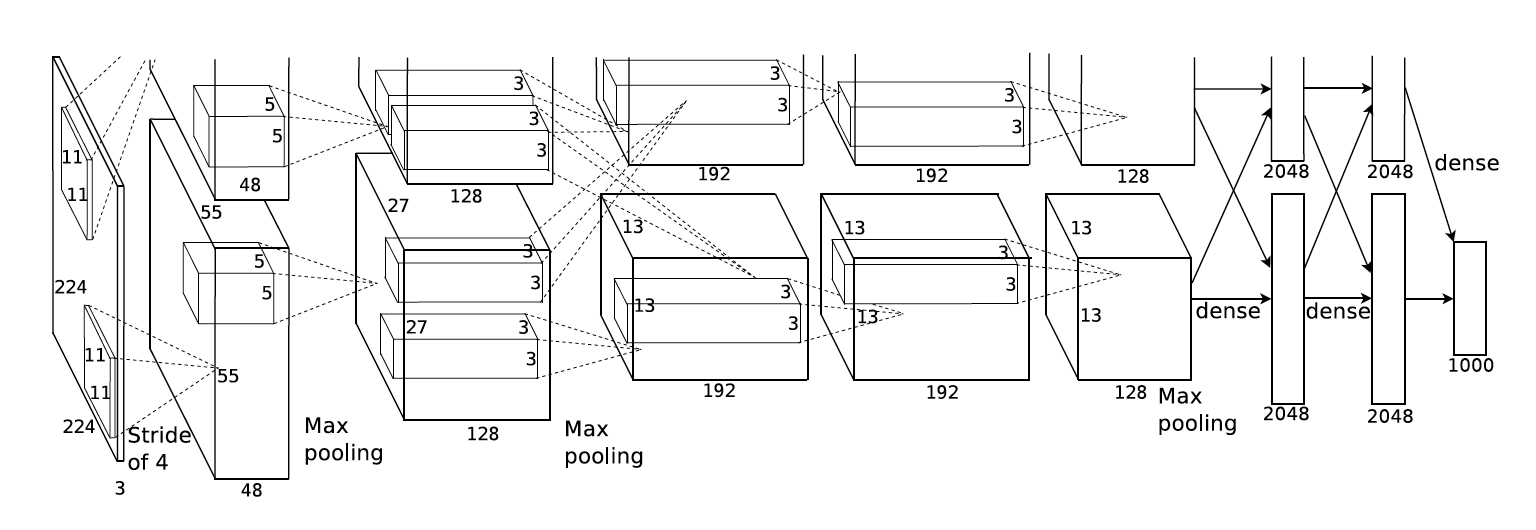

There is an mistake on the image, the input layer size is 227x227x3 not 224x224x3.

> Originally AlexNet was trained on two GPU's, as shown on the image above, so
> architecture was "splitted" in two, because in this notebook
> I'll use only one GPU, then channels count in every convolution layer and >number of hidden neurons in fully-connected layers must be doubled.

> I've provided a seperate file "alexnet.py" with model implementation.

In [1]:
from alexnet import AlexNet
from utils import *

Matplotlib is building the font cache; this may take a moment.


## **3. Hyperparameters Tuning**

> Creating arrays of hyperparameters to search across them.

In [5]:
lr = 10**np.linspace(0, -7, 8)
k = np.arange(1, 11, 1)
n = np.arange(1, 11, 1)
alpha = 10**np.linspace(0, -7, 8)
beta = np.arange(0, 1.1, 0.1)
momentum = np.linspace(0.1, 0.9, 9)
weight_decay = 10**np.linspace(0, -7, 8)

In [ ]:
best_params = None
best_loss = np.inf

search_iterations = 100

for i in range(search_iterations):
  lr_i = np.random.choice(lr)
  k_i = np.random.choice(k)
  n_i = np.random.choice(n)
  alpha_i = np.random.choice(alpha)
  beta_i = np.random.choice(beta)

  model = AlexNet(k=k_i, n=n_i, alpha=alpha_i, beta=beta_i)
  optimizer = optim.SGD(model.parameters(), lr=lr_i, momentum=0.9, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()

  loss = train(model, optimizer, criterion, valid_loader)

  if loss < best_loss:
    print("Have found new best parameters, loss {}, iteration {}.".format(loss, (i+1)))
    best_params = (lr_i, k_i, n_i, alpha_i, beta_i)
    best_loss = loss

> If needed, above cells can be used for hyperparameters tuning, but it </br>
> turns out, that parameters introduced in paper works as well on </br>
> CIFAR-10 dataset.

## **4. Training**

In [ ]:
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

val_losses = []
tr_losses = []

best_val_loss = np.inf

epochs = 90

for epoch in range(epochs):
  tr_loss = train(model, optimizer, criterion, train_loader)

  print("\nLoss in epoch {}: {}".format((epoch+1), tr_loss))

  if (epoch+1) % 5 == 0:
    val_loss = validate(model, criterion, valid_loader)
    print("Validation loss in epoch {}: {}".format((epoch+1), val_loss))

    if val_loss < best_val_loss:
      best_val_loss = val_loss

      print("Saving new best set of parameters.")
      torch.save(model.state_dict(), "./alexnet_state.pt")

    val_losses.append(val_loss)
    tr_losses.append(tr_loss)

> Retrieving the best set of parameters for model.

In [ ]:
model.load_state_dict(torch.load("./alexnet_state.pt"))

## **5. Results**

> Let's see if model doesn't overfit or underfit.

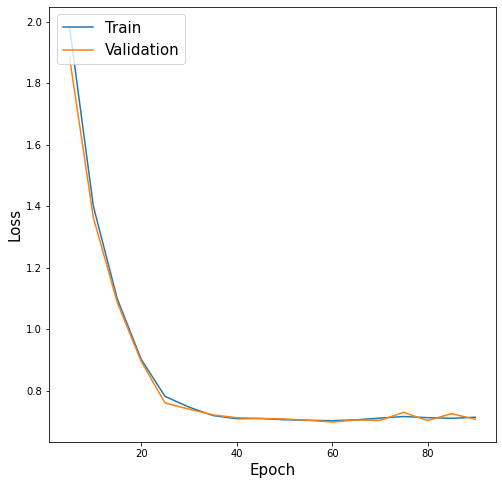

In [9]:
plot_learning_curves(tr_losses, val_losses)

> On the chart we can see, that model fits fine to the test data, </br>
> but there is a place for improvement, as we can see on the plot </br>
> validation loss and training loss are increasing and decreasing after epoch 70,
> it could be due to high learning rate, so decreasing it over the number of epochs should increase model performance.

In [10]:
print("Model Accuracy: {:.2%}".format(evaluate_acc(model, test_loader)))

Model Accuracy: 69.23%
